# Continous PDE Dynamics Forecasting with Implicit Neural Representations

### Yin et al., ICLR 2023

Tutorial presented by: Jaisidh Singh and Arkadijs Sergejevs

## Introduction

- Partial differential equations (PDEs) are indispensible tools to model the dynamics and temporal evolution of physical phenomena.

- In classical methods, the dynamics described by PDEs are solved by numerical solvers, which are highly accurate but computationally slow.

- Recently, data produced by simulations has enabled deep learning based PDE forecasting, which what this work deals with.

## Motivation and Problem Statement

- PDE forecasting in areas like weather prediction can require extrapolation through new and arbitrary points in time or space.

- Current data-driven forecasting methods have notable drawbacks as they often rely fixed discretizations of the space domain, hence they

    1. Do not generalize outside the space seen during training (train grid)
    2. Show poor evaluation at unobserved spatial locations and on free-form grids.
    3. May not forecast well on new initial conditions
    4. Cannot forecast long-term (outside training horizon).

## Proposed solution

- This work presents `DINo`, a method using continuous-time dynamics of spatially continuous functions. This is done by 

    1. using Implicit Neural Representations (INRs) to embed spatial observations independently of how they were discretized. 
    2. At the same time, the temporal progress is modeled with an ordinary differential equation (ODE) in the latent embedding space.

## PDE Refresher

**Formally**: A PDE involves a function $u(x, t)$ and its partial derivative such that 

$$F(x, t, u(x, t), \frac{\partial}{\partial x}u(x, t), \frac{\partial^2}{\partial x^2}u(x, t), \dots) = 0$$

**Intuitively**: Since $u(x, t)$ is a time-varying function of space, we can also denote it as $v_t(x) = u(x, t)$ which is described by the same PDE.

### Example: Heat Equation

Given by $\frac{\partial}{\partial t}u(x, t) = k \frac{\partial^2}{\partial x^2} u(x, t)$, this PDE is visualised in 2D space below, with $k = 0.02$ and all boundaries insulated at $0$:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from matplotlib.animation import FuncAnimation

plt.ioff()

nx, ny = 50, 50  # Number of grid points
dx = dy = 0.1    # Grid spacing
alpha = 0.02     # Thermal diffusivity
dt = 0.1         # Time step (chosen for stability)
steps = 200      # Number of animation frames
skip = 3         # Show every nth arrow

x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x, y)
u = np.zeros((ny, nx))
u[ny//3:2*ny//3, nx//3:2*nx//3] = 100  # Square hot region
u += 50 * np.exp(-((X-1)**2 + (Y-1)**2)/0.5)  # Gaussian hot spot

def evolve_temperature(u):
    d2udx2 = (np.roll(u, 1, axis=1) - 2*u + np.roll(u, -1, axis=1)) / (dx**2)
    d2udy2 = (np.roll(u, 1, axis=0) - 2*u + np.roll(u, -1, axis=0)) / (dy**2)
    
    dudt = alpha * (d2udx2 + d2udy2)
    return u + dt * dudt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('2D Heat Equation')

heatmap = ax1.imshow(u, extent=[-2, 2, -2, 2], origin='lower', 
                     cmap='inferno', vmin=0, vmax=100)
plt.colorbar(heatmap, ax=ax1, label='Temperature')
ax1.set_title('Temperature Field')

dx_temp = np.gradient(u, dx, axis=1)
dy_temp = np.gradient(u, dy, axis=0)
quiver = ax2.quiver(
    X[::skip, ::skip], 
    Y[::skip, ::skip],
    dx_temp[::skip, ::skip], 
    dy_temp[::skip, ::skip],
    np.sqrt(dx_temp[::skip, ::skip]**2 + dy_temp[::skip, ::skip]**2),
    cmap='viridis'
    )
plt.colorbar(quiver, ax=ax2, label='Temperature Gradient Magnitude')
ax2.set_title('Temperature Gradient')

def update(frame):
    global u
    
    u = evolve_temperature(u)
    heatmap.set_array(u)
    
    dx_temp = np.gradient(u, dx, axis=1)
    dy_temp = np.gradient(u, dy, axis=0)
    quiver.set_UVC(dx_temp[::skip, ::skip], dy_temp[::skip, ::skip],
                   np.sqrt(dx_temp[::skip, ::skip]**2 + dy_temp[::skip, ::skip]**2))
    
    return heatmap, quiver

ani = FuncAnimation(fig, update, frames=steps, interval=50, blit=True)
ani.save("heat_equation_2d.gif", writer="pillow")

plt.cla()
plt.clf()

HTML('<img src="heat_equation_2d.gif" width="1000" align="center">')

<Figure size 1200x500 with 0 Axes>

## `DINo` Notation and Formulation

Given function $v_t(x)$ described by the PDE, `DINo` learns a flow $\Phi_\tau$ to predict the spatial function $\tau$ steps ahead, i.e., $v_{t+T}(x)$. Learning the flow is a common strategy in sequential models to better generalize beyond the train time horizon. So, `DINo` learns the flow $\Phi \quad \forall v \in \Tau$, where ($\Tau$ is training set of functions) such that

$$(v_t, \tau) \mapsto \Phi_\tau(v_t) = v_{t+\tau}$$


The flow $\Phi$ denotes the overall architecture of `DINo` that we describe next.

## Brief Overview of Architecture

Here's how `DINo` forecasts a PDE given its value at $t=0$, i.e., $v_0$. 

1. **Encoder**: First it embeds $v_0$ to $\alpha_0 \in \mathbb{R}^{d_\alpha}$ via an encoder of spatial functions $E_\varphi(v_0) = \alpha_0$.
2. **Dynamics model**: Then it unrolls to time $t$ via a latent time-continous model (latent ODE) $f_\psi: \alpha_0 \mapsto \alpha_t$ given this initial condition. Specifically, $\frac{d\alpha_t}{dt} = f_\psi(\alpha_t)$.
3. **Decoder**: Finally, it decodes the latent vectors via a decoder $D_\phi(\alpha_t) = \tilde{v}_t$.


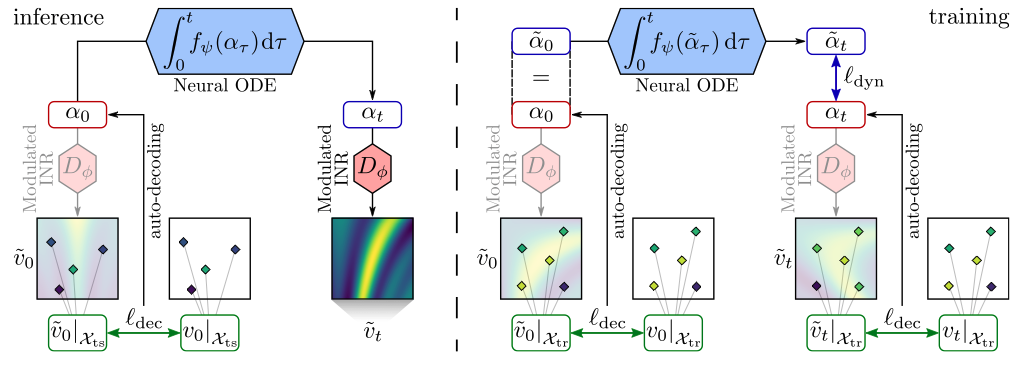

## Deep-Dive into `DINo` Architecture

### Encoder: $\alpha_t=E_\varphi(v_t)$. 

The encoder computes a latent vector $\alpha_t$ given observation $v_t$ at any time $t$, and is used differently for train and test.

**Train**: Given an observed trajectory $v_{\Tau}=\{v_t\}_{t\in\Tau}$, it will encode any $v_t$ into $\alpha_t$.

**Test**: During inference, only $v_0$ is available, and then only $\alpha_0$ is computed to be used as initial value for the dynamics.

The encoder is not used in a typical autoencoder fashion. Particularly, given the decoder $D_\phi$, $\alpha_t$ is a solution to the inverse problem $D_\phi(\alpha_t)=v_t$.

This inverse problem is solved with *auto-decoding*: $\mathcal{L}_{\text{dec}}(\phi,\alpha_{t};v_t)=\|D_\phi(\alpha_t)-v_t\|_2^2$ the decoding loss where $\|{\cdot}\|_2$ is the euclidean norm of a function and $K$ the number of update steps, auto-decoding defines $E_\varphi$ as:

$$E_\varphi(v_t) = \alpha_t^K, \quad \text{where }\alpha_t^0 = \alpha_t; \quad \forall k>0, \text{ } \alpha_t^{k+1} = \alpha_t^{k} - \eta \nabla_{\alpha_t} \mathcal{L}_{\text{dec}}(\phi,\alpha^{k}_{t};v_t) \quad \text{ and }\varphi=\phi$$

In [3]:
# Architecture helper code

import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial


class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor([0.5]))

    def forward(self, x):
        return (x * torch.sigmoid_(x * F.softplus(self.beta))).div_(1.1)


nls = {'relu': partial(nn.ReLU),
       'sigmoid': partial(nn.Sigmoid),
       'tanh': partial(nn.Tanh),
       'selu': partial(nn.SELU),
       'softplus': partial(nn.Softplus),
       'gelu': partial(nn.GELU),
       'swish': partial(Swish),
       'elu': partial(nn.ELU)}

class MLP(nn.Module):
    def __init__(self, code_size, hidden_size, out_size=None, nl='swish'):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(code_size, hidden_size), 
            nls[nl](), 
            nn.Linear(hidden_size, hidden_size),
            nls[nl](), 
            nn.Linear(hidden_size, hidden_size), 
            nls[nl](), 
            nn.Linear(hidden_size, code_size if out_size == None else out_size),
        )

    def forward(self, x):
        return self.net(x)
    

### Decoder: $\tilde{v}_t = D_\phi(\alpha_t)$

A flexible decoder is defined using a coordinate-based INR network with parameters conditioned on $\alpha_t$.

#### Quick primer on INRs

An INR $I_\theta\colon\Omega\to\R^n$ is a space-continuous model parameterized by $\theta\in\R^{d_\theta}$ defined on domain $\Omega$. It approximates functions independently of the observation grid, and thus handles irregular grids and new conditions.

#### INRs in `DINo`

In this work, the INR in use is a `FourierNet` which can be thought of as an MLP in Fourier space. For some spatial location $x$, we first write a Fourier basis to use in layer $l$ of the INR as $s_{\omega^{(l)}}(x) = [\cos(w^{(l)})(x), \sin(w^{(l)})(x)]$. Then for every $1 \leq l \leq L$, 

$$ z^{(l)}(x) = (W^{(l-1)} z^{(l-1)}(x) + b^{(l-1)}) \odot s_{\omega^{(l-1)}}(x); \quad z^{(0)}(x) = s_{\omega^{(0)}}(x) = x $$

Here, $W^{(0)} = 0, b^{(0)} = 1$ and $\odot$ is the element-wise or Hadamard product. The goal is that $\forall x, z^{(L)}(x) = v(x)$.

**Modulating the INR**: A hypernetwork is used to condition the INR's parameters $h_{\phi}\colon \R^{d_\alpha}\rightarrow \R^{d_\theta}$. It generates high-dimensional parameters $\theta_t \in {\R^{d_\theta}}$ of the INR given the low-dimensional latent vector $\alpha_t\in\R^{d_\alpha}$. 

Hence, the decoder $D_{\phi}$, parameterized by $\phi$, is defined as:

$${\forall x\in\Omega, \quad \tilde{v}_t(x)=D_{\phi}(\alpha_{t})(x) \triangleq I_{h_{\phi}(\alpha_{t})}(x).}$$

The decoder can be understood visually by the following figure:

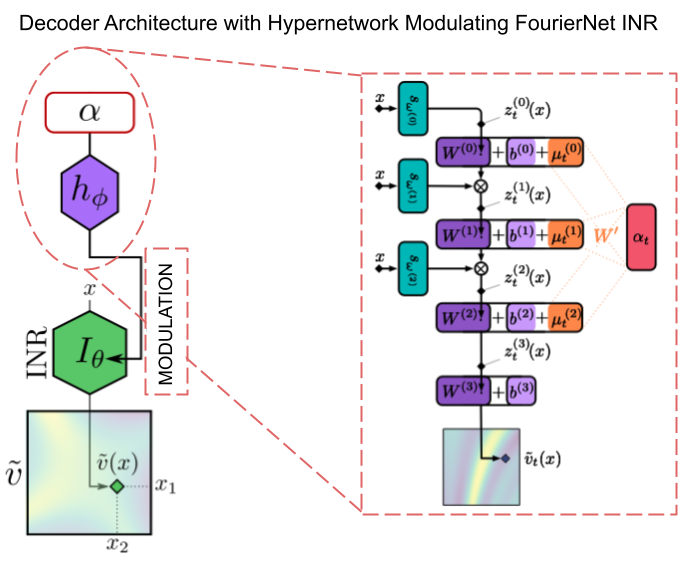

In [ ]:
import math
from torch import Tensor


class CodeBilinear(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, device=None, dtype=None) -> None:
        """
        x2T A + B x1
        x2: code, x1: spatial coordinates
        """
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(CodeBilinear, self).__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.A = nn.Parameter(torch.empty(out_features, in2_features, **factory_kwargs))
        self.B = nn.Parameter(torch.empty(out_features, in1_features, **factory_kwargs))
        self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.in1_features)
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.B, a=math.sqrt(5))
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input1: Tensor, input2: Tensor) -> Tensor:
        # input1: b, t, h, w, s, i
        # input2: b, t, s, j
        # W: o, i, j
        # B: o, i
        # A: o, j
        # bias: o
        res = 0
        
        bias_code = torch.einsum('btsj,oj->btso', input2, self.A)
        bias_code = bias_code.unsqueeze(2).unsqueeze(2)

        linear_trans_2 = torch.einsum('bthwsi,oi->bthwso', input1, self.B)
       
        res += linear_trans_2 
        res += bias_code
        res += self.bias
        return res
        
    def extra_repr(self) -> str:
        return 'in1_features={}, in2_features={}, out_features={}, bias={}'.format(
            self.in1_features, self.in2_features, self.out_features, self.bias is not None)


class MFNBase(nn.Module):
    def __init__(self, in_size, hidden_size, code_size, out_size, n_layers):
        super().__init__()
        self.first = 3
        self.bilinear = nn.ModuleList(
            [CodeBilinear(in_size, code_size, hidden_size)] +
            [CodeBilinear(hidden_size, code_size, hidden_size) for _ in range(int(n_layers))]
        )
        self.output_bilinear = nn.Linear(hidden_size, out_size)
        return

    def forward(self, x, code):
        out = self.filters[0](x) * self.bilinear[0](x*0., code)
        for i in range(1, len(self.filters)):
            out = self.filters[i](x) * self.bilinear[i](out, code)
        out = self.output_bilinear(out)
        if out.shape[-1] == 1:
            out = out.squeeze(-1)
        return out, x


class FourierLayer(nn.Module):
    def __init__(self, in_features, out_features, weight_scale):
        super().__init__()
        self.weight = nn.Parameter(torch.empty((out_features, in_features)))
        self.weight_scale = weight_scale
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

    def forward(self, x):
        return torch.cat([torch.sin(F.linear(x, self.weight * self.weight_scale)), torch.cos(F.linear(x, self.weight * self.weight_scale))], dim=-1)


class FourierNet(MFNBase):
    def __init__(self, in_size, hidden_size, code_size, out_size, n_layers=3, input_scale=256.0, **kwargs):
        super().__init__(in_size, hidden_size, code_size, out_size, n_layers)
        self.filters = nn.ModuleList(
                [FourierLayer(in_size, hidden_size // 2, input_scale / np.sqrt(n_layers + 1)) for _ in range(n_layers + 1)])
    
    def get_filters_weight(self):
        weights = list()
        for ftr in self.filters:
            weights.append(ftr.weight)
        return torch.cat(weights)


class Decoder(nn.Module):
    def __init__(self, state_c, hidden_c, code_c, coord_dim, n_layers, **kwargs):
        super().__init__()
        self.state_c = state_c
        self.hidden_c = hidden_c
        self.coord_dim = coord_dim
        self.out_dim = 1
        self.code_dim = code_c
        self.net = FourierNet(self.coord_dim, self.hidden_c, self.code_dim, self.out_dim, n_layers, input_scale=64)

    def forward(self, x, codes=None):
        if codes is None:
            return self.net(x)
        return self.net(x, codes)

### Dynamics model: $\frac{d\alpha_t}{dt} = f_\psi(\alpha_t)$

Finally, the dynamics model $f_{\psi}\colon \R^{d_\alpha}\rightarrow\R^{d_\alpha}$ defines a flow via an ODE in the latent space. The initial condition can be defined at any time $t$ by encoding with $E_\varphi$ the corresponding input function $v_t$.


In [ ]:
class Derivative(nn.Module):
    def __init__(self, state_c, code_c, hidden_c, **kwargs):
        super().__init__()
        input_dim = code_c * state_c
        self.net = MLP(input_dim, hidden_c, nl='swish')

    def forward(self, t, u):
        return self.net(u)

### Overall flow:

Combined altogether, our components define the following flow in the input space that can approximate the data flow $\Phi$ as    

$$\forall(t, \tau), \qquad (v_t, \tau) \mapsto D_\phi(E_\varphi(v_t) + \int_t^{t+\tau} f_\psi(\alpha_{\tau'}) d \tau') \quad \text{ where }\alpha_t=E_\varphi(v_t).$$